# Data convertion/reformat for Neuron Growth Model
##### Reads neuron growth model generated results (mat) and convert all data into same size numpy array (saved as .npy)
##### Dependency: glob, numpy, scipy, tqdm, and os. matplotlib (optional)

In [1]:
import glob
import numpy as np
import scipy.io
from tqdm import tqdm
import h5py
import re

# function to expand the input matrix based on expd_size
def expd(original_mat, expd_size):
    sz_diff = np.floor((expd_size-original_mat.shape[0])/2).astype(int)
    output = np.zeros([expd_size,expd_size])
    output[sz_diff:sz_diff+original_mat.shape[0], sz_diff:sz_diff+original_mat.shape[1]] = original_mat
    return output

# check and create output folder
import os
outputFolder = './reformattedData_20220523'
try:
    os.makedirs(outputFolder)
except:
    pass

# get all cases folder name
cases = glob.glob('./case*')
cases.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

save_freq = '00' # 0 for per10, 00 for per 100
expd_size = 400 # target domain size
dwn = 4 # down sample ratio
dwn_sz = int(expd_size/dwn)

hdf5_file = h5py.File(outputFolder+'/CNN_'+str(int(dwn_sz))+'x'+str(int(dwn_sz))+'_per1'+save_freq+'_prePhi_tipsTheta_2channels_compressed.hdf5', mode='w')
# allocate dataset
total_length = 0
for case in cases:
    total_length += len(glob.glob(case+'/phi_*'+save_freq+'.mat'))
hdf5_file.create_dataset("input", (total_length, 2, dwn_sz, dwn_sz), np.float64, chunks=(1,1,dwn_sz,dwn_sz), compression="gzip")
hdf5_file.create_dataset("output", (total_length, 1, dwn_sz, dwn_sz), np.float64, chunks=(1,1,dwn_sz,dwn_sz), compression="gzip")
hdf5_file.create_dataset("theta", (total_length, 1, dwn_sz, dwn_sz), np.float64, chunks=(1,1,dwn_sz,dwn_sz), compression="gzip")

count = 0
for i in tqdm (range(len(cases)), desc="Running ..."):
    inputFolder = cases[i]
    case = inputFolder.replace('./','')

    # load and expand theta
    thetaPath = glob.glob(inputFolder+'/theta_35000.mat')
    theta_temp = np.array(scipy.io.loadmat(thetaPath[0])['theta_plot'].todense())
    thetaExpd = expd(theta_temp, expd_size)
    thetaExpd_dwn = thetaExpd[0::dwn,0::dwn]

    # defined input data folder and grab a list of data files
    phiPath = glob.glob(inputFolder+'/phi*'+save_freq+'.mat') # 0 to sample data per 10 data points
    phiPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    phiLength = len(phiPath)
    
    phiPre = np.zeros([expd_size,expd_size])
    phiPre_temp = scipy.io.loadmat(case+'/phi_10.mat')['phi_plot']
    phiPre = expd(phiPre_temp, expd_size)
    phiPre_dwn = phiPre[0::dwn,0::dwn]

    # load and expand theta
    tipsPath = glob.glob(inputFolder+'/tips*'+save_freq+'.mat')
    tipsPath.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

    phiPre_initial = phiPre_dwn

    for j in range(phiLength):
        # load data
        s = phiPath[j]
        phi_temp = scipy.io.loadmat(s)['phi_plot']
        original_sz = phi_temp.shape[0]

        data_target = expd(phi_temp, expd_size)
        data_target_dwn = data_target[0::dwn,0::dwn]

        tips_temp = np.array(scipy.io.loadmat(tipsPath[j])['theta_ori'])
        tipsExpd = expd(tips_temp, expd_size)
        tipsExpd_dwn = tipsExpd[0::dwn,0::dwn]
        
        iterMat = np.ones((dwn_sz,dwn_sz))*int(s.replace(inputFolder+'/phi_','').replace('.mat',''))
        data_train_dwn = np.array([phiPre_dwn,np.multiply(tipsExpd_dwn,thetaExpd_dwn)])

        hdf5_file["input"][count,...] = data_train_dwn
        hdf5_file["output"][count,...] = data_target_dwn
        hdf5_file["theta"][count,...] = thetaExpd_dwn
        count += 1

        phiPre_dwn = data_target_dwn

hdf5_file.close()

Running ...: 100%|██████████| 64/64 [01:56<00:00,  1.82s/it]


In [9]:
tipsPath = glob.glob(inputFolder+'/tips*'+save_freq+'.mat')
tipsPath
i
cases[i]

'./case51'

In [5]:
import h5py
# h5 = h5py.File(outputFolder+'/CNN_all_cases_'+str(int(dwn_sz))+'x'+str(int(dwn_sz))+'_per1'+save_freq+'_compressed.hdf5', mode='r')
h5 = h5py.File('./reformattedData_20220523/CNN_200x200_per100_prePhi_tipsTheta_2channels_compressed.hdf5', mode='r')
ind = h5.get('input')
oud = h5.get('output')
thet = h5.get('theta')
ind.shape

(21343, 2, 200, 200)

In [6]:
oud.shape

(21343, 1, 200, 200)

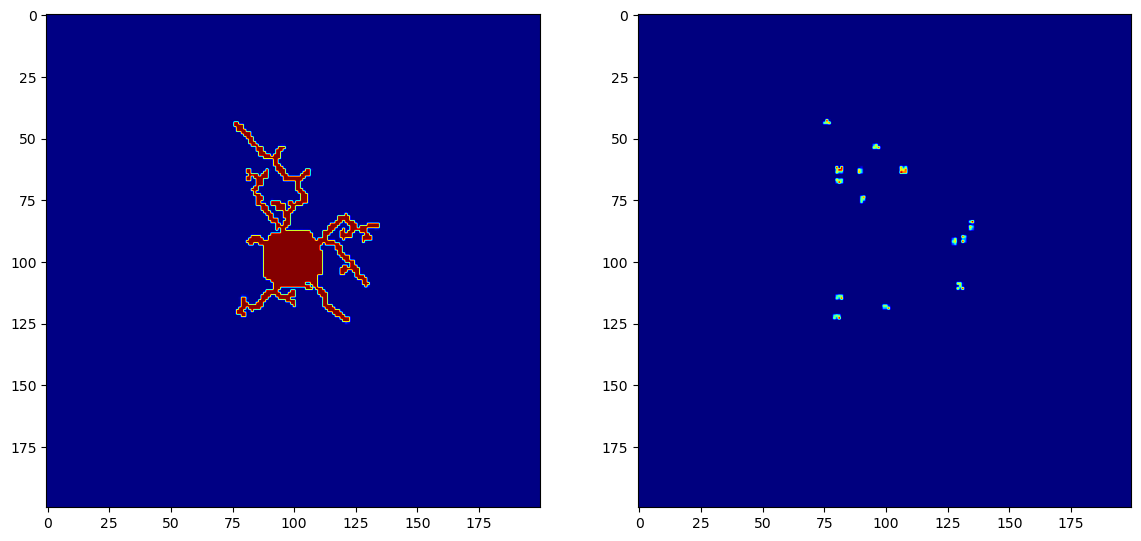

In [7]:
import matplotlib.pyplot as plt
id = 1001

plt.figure(figsize=(14, 10), dpi=100)
plt.subplot(1,2,1)
plt.imshow(ind[id,0,:,:], cmap='jet')
plt.subplot(1,2,2)
plt.imshow(ind[id,1,:,:], cmap='jet')

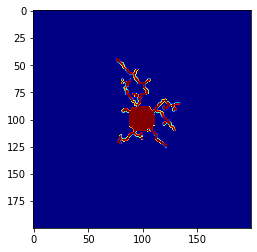

In [5]:
plt.imshow(oud[id,0,:,:], cmap='jet')

In [3]:
import numpy as np

A = np.random.rand(5)
np.around(A)

array([1., 0., 1., 1., 0.])